# Ini Anomalias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

In [2]:
dftemp=pd.read_csv('Horno4.csv', index_col=[0], parse_dates=True, low_memory=True)
dftemp.sort_index(inplace=True)
dftemp=dftemp.resample("min").first()
dftemp=dftemp.interpolate(method='time')

In [3]:
dftemp.index=dftemp.index.tz_convert(None)

In [4]:
termo_horno=['k1', 'k2', 'k3', 'k4', 's5', 's6', 's7', 's8', 's9', 's10', 's11','s12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 'k21','k22', 'k23', 'k24', 'k25', 'k26']

In [10]:
dftemp['s18'].pct_change(1).describe()

count    5.091930e+05
mean     4.799881e-07
std      9.203875e-04
min     -3.418882e-01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.912568e-02
Name: s18, dtype: float64

In [5]:
df_diff=pd.DataFrame()
for i in termo_horno:
    df_diff[i+'diff']=dftemp[i]-dftemp[i+'sp']

<Axes: >

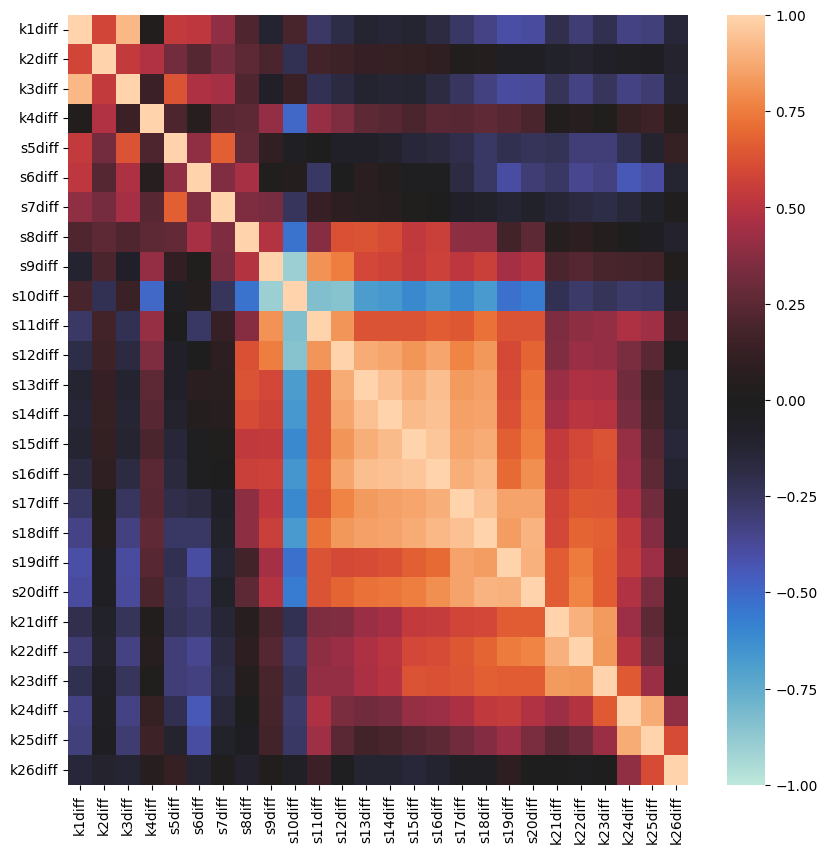

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(df_diff.corr(), vmin=-1.0, vmax=1.0,center=0.0)

| par     | id | poblacion | porcentaje | termos_muestra |
|---------|----|-----------|------------|----------------|
| k1-s8   | 1  | 8         | 31%        | 2              |
| s9-s20  | 2  | 12        | 46%        | 5              |
| k21-k26 | 3  | 6         | 23%        | 1              |

In [6]:
termos=['k1diff','s8diff','s9diff','s12diff','s15diff','s18diff', 's19diff','k24diff']

In [7]:
dfsample=df_diff[termos].copy()

## PCA ENCODIGN

In [91]:
def temperaturas_turnos(hora:str,df):
    id_hora=df.index.strftime('%H:%M').values
    turnos_=np.where(id_hora==hora)[0]
    temp_ent=[]
    for _ in range(len(turnos_)-1):
        temp_ent.append(df.iloc[turnos_[_]:turnos_[_+1], :].values)
    temp_ent=np.array(temp_ent)
    return temp_ent,turnos_

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest

In [12]:
#turnos_=temperaturas_turnos('06:00', dfsample)

In [15]:
A= lambda x: x[:-4]
muestras_=list(map(A,termos))

In [13]:
def plot_anomalias(date_, dftemp, res,muestras_):
    cond_01=(dftemp.index.to_period('d')==date_)
    res01=res[dftemp.index.to_period('d')==date_]
    value_=np.where(res01==-1,True, False)
    fig, axs = plt.subplots(nrows=4, ncols=2,figsize=(25,30), dpi=150)
    axs = axs.flatten()
    for i,j in enumerate(muestras_):
        axs[i].set_title(j)
        axs[i].plot(dftemp.loc[cond_01,[j]])
        axs[i].plot(dftemp.loc[cond_01,[j+'sp']])
        axs[i].plot(dftemp.loc[cond_01].loc[value_,[j]],'or')

### Pipeline

In [9]:
anomalia_pipeline=make_pipeline(PCA(5),
                                IsolationForest(n_jobs=-1, n_estimators=150, max_samples=15, contamination=0.2, bootstrap=False))

In [10]:
anomalia_pipeline.fit(dfsample.values)

Pipeline(steps=[('pca', PCA(n_components=5)),
                ('isolationforest',
                 IsolationForest(contamination=0.2, max_samples=15,
                                 n_estimators=150, n_jobs=-1))])

In [ ]:
# import joblib
# joblib.dump(anomalia_pipeline, 'deteccion_anomalia.sav')

['deteccion_anomalia.sav']

In [11]:
res=anomalia_pipeline.predict(dfsample.values)

In [109]:
date_='2024-08-11' #08-11
cond_01=(dftemp.index.to_period('d')==date_)
res01=res[dftemp.index.to_period('d')==date_]
value_=np.where(res01==-1,True, False)

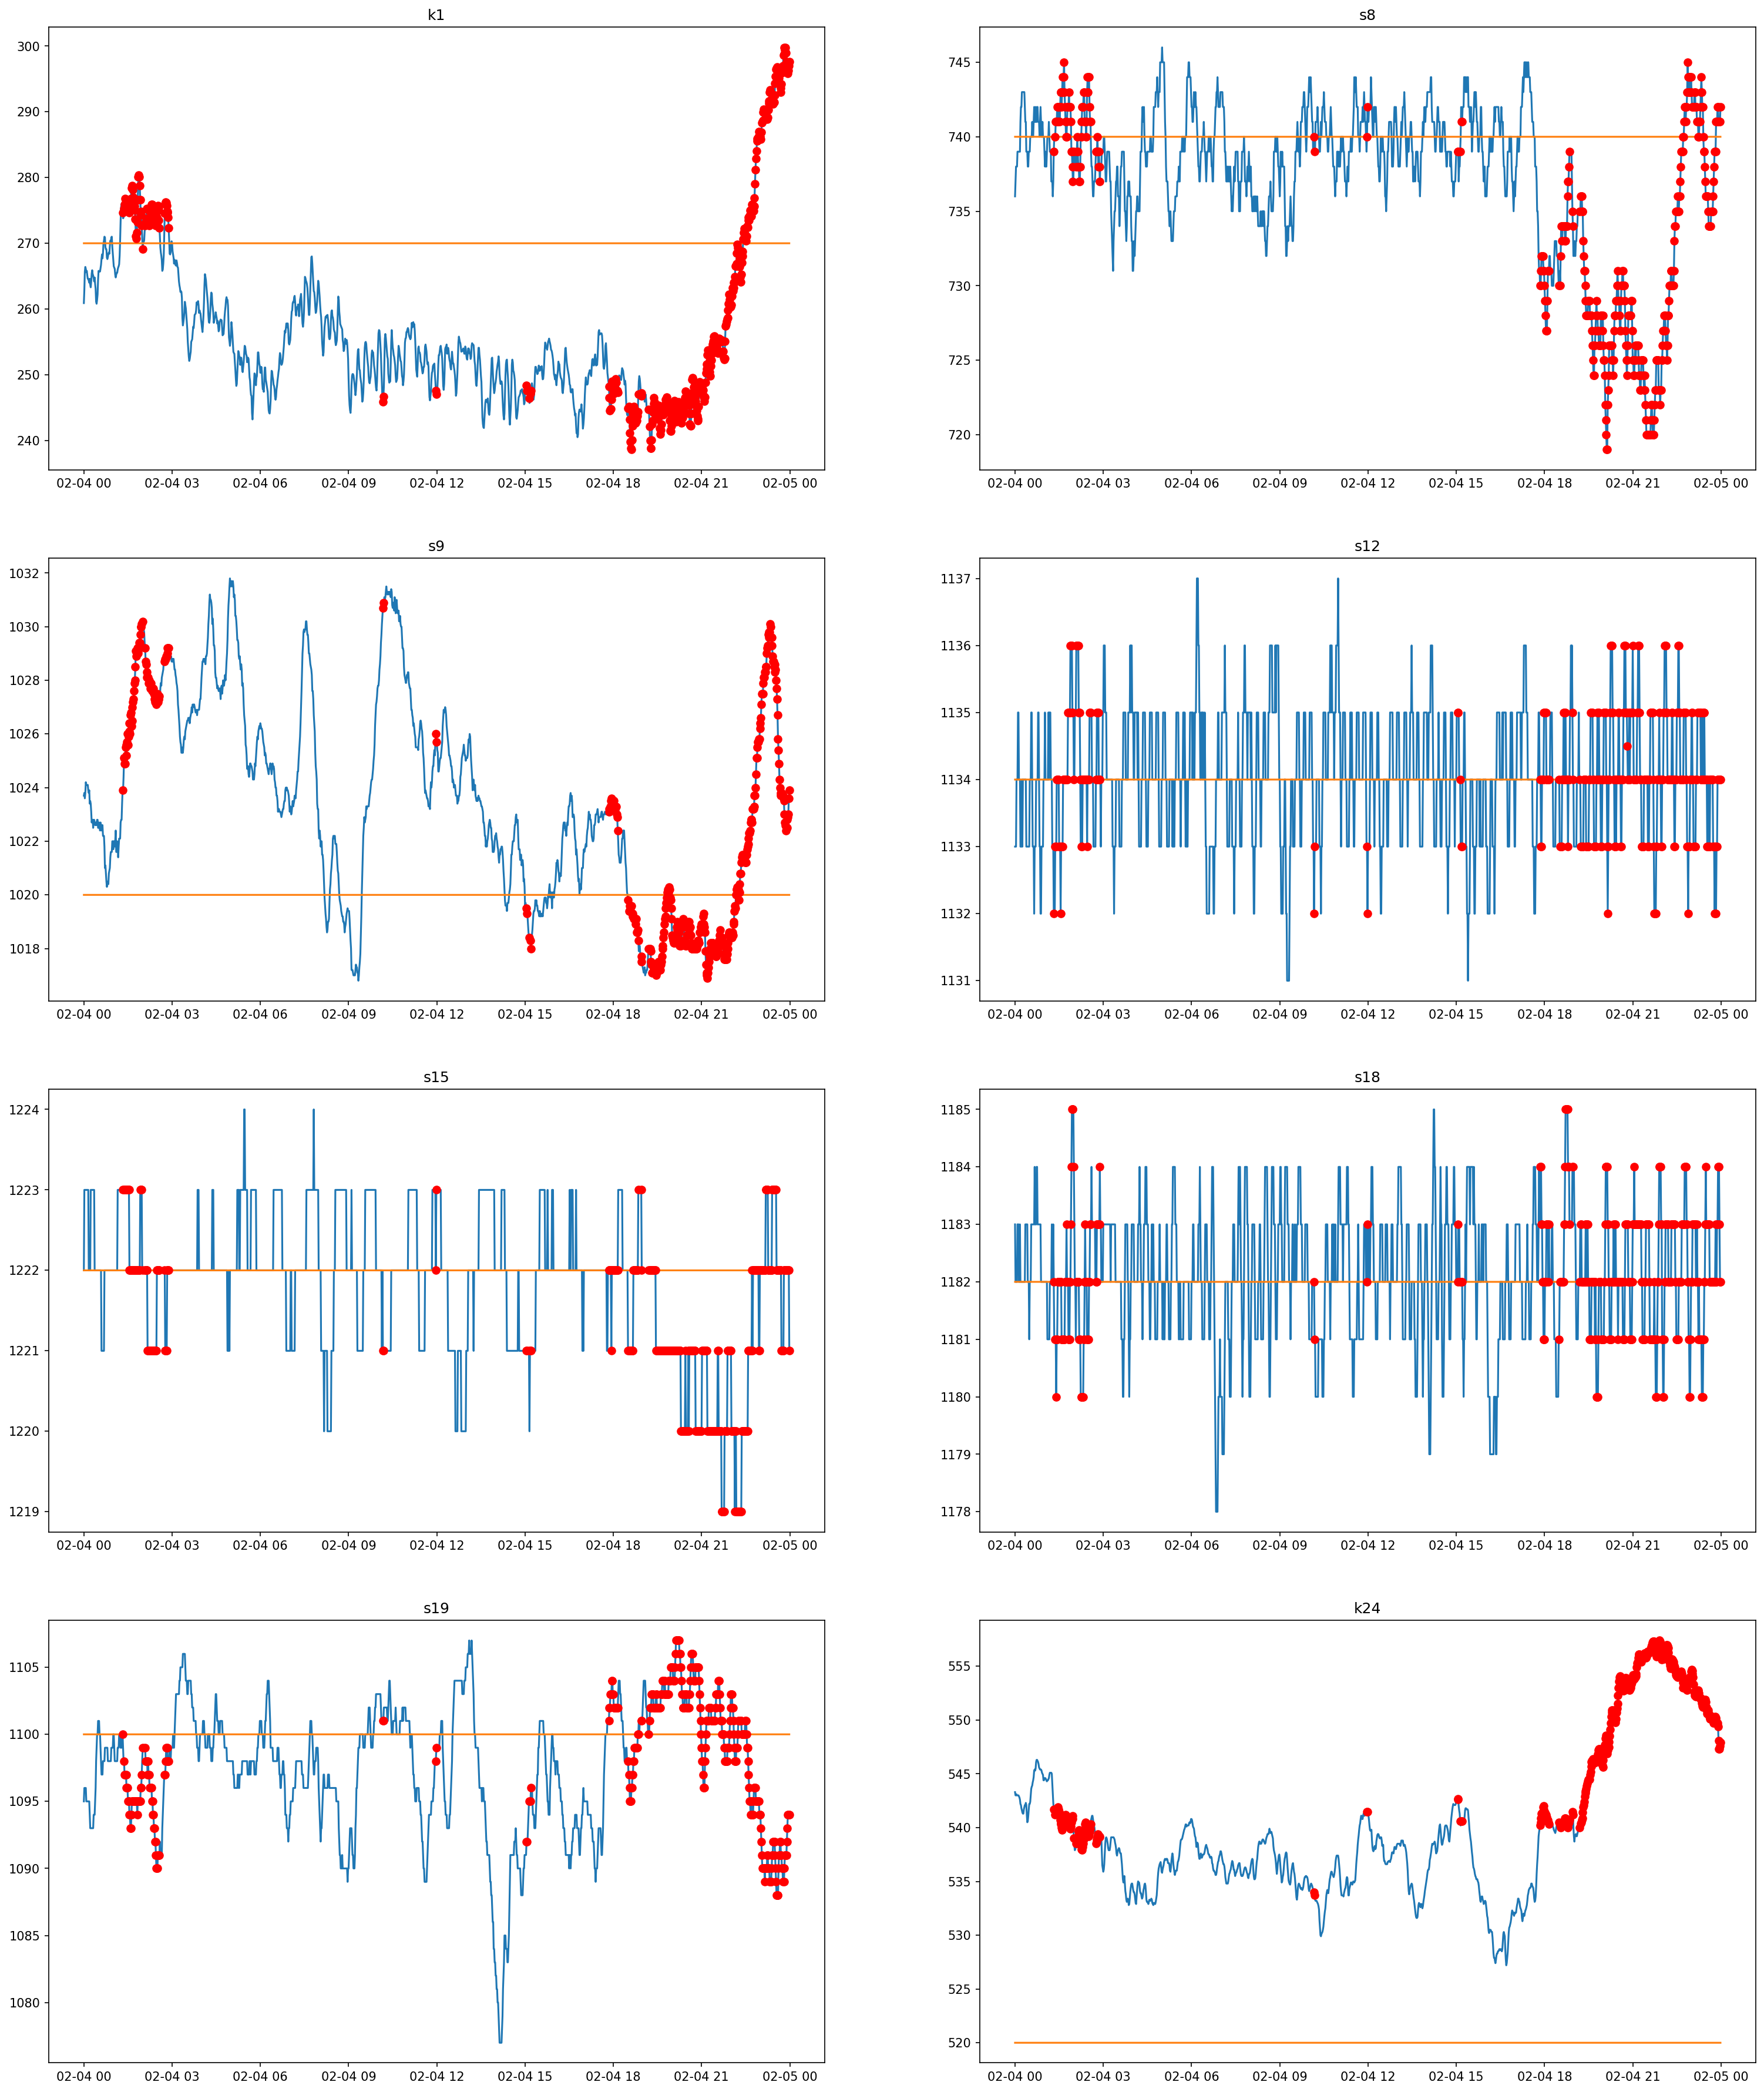

In [16]:
plot_anomalias('2024-02-04', dftemp, res,muestras_)

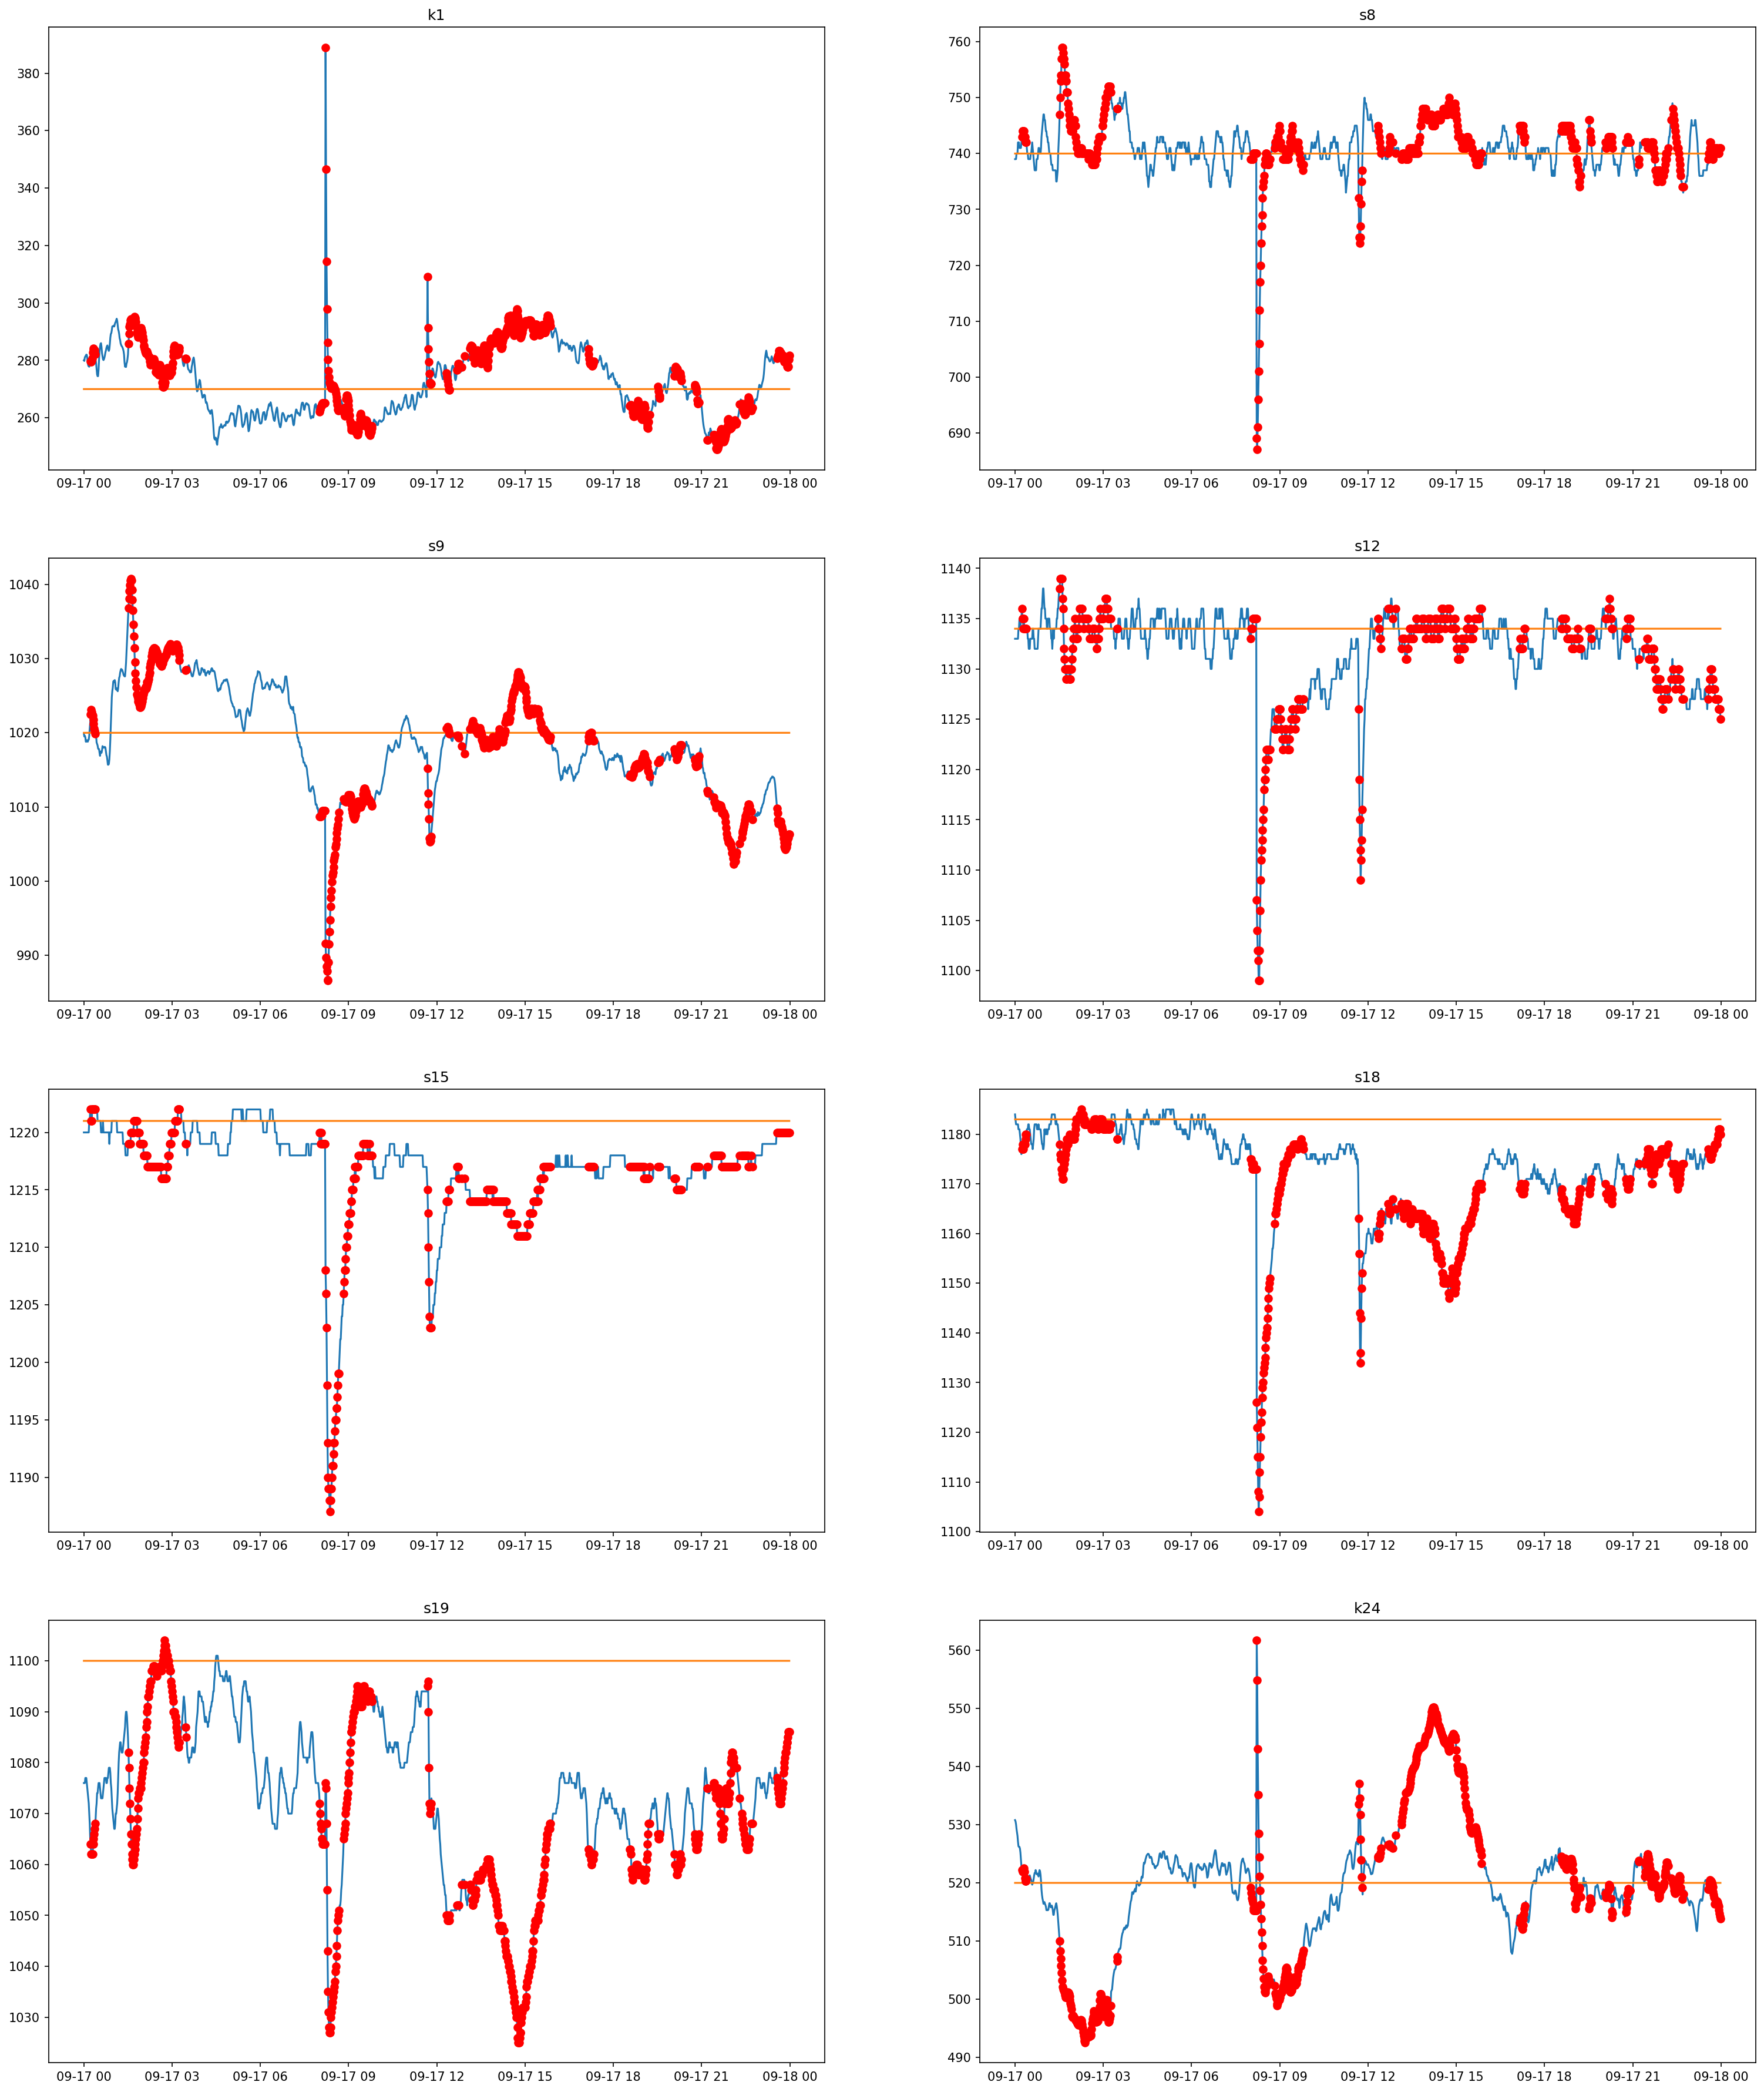

In [17]:
plot_anomalias('2024-09-17', dftemp, res,muestras_)

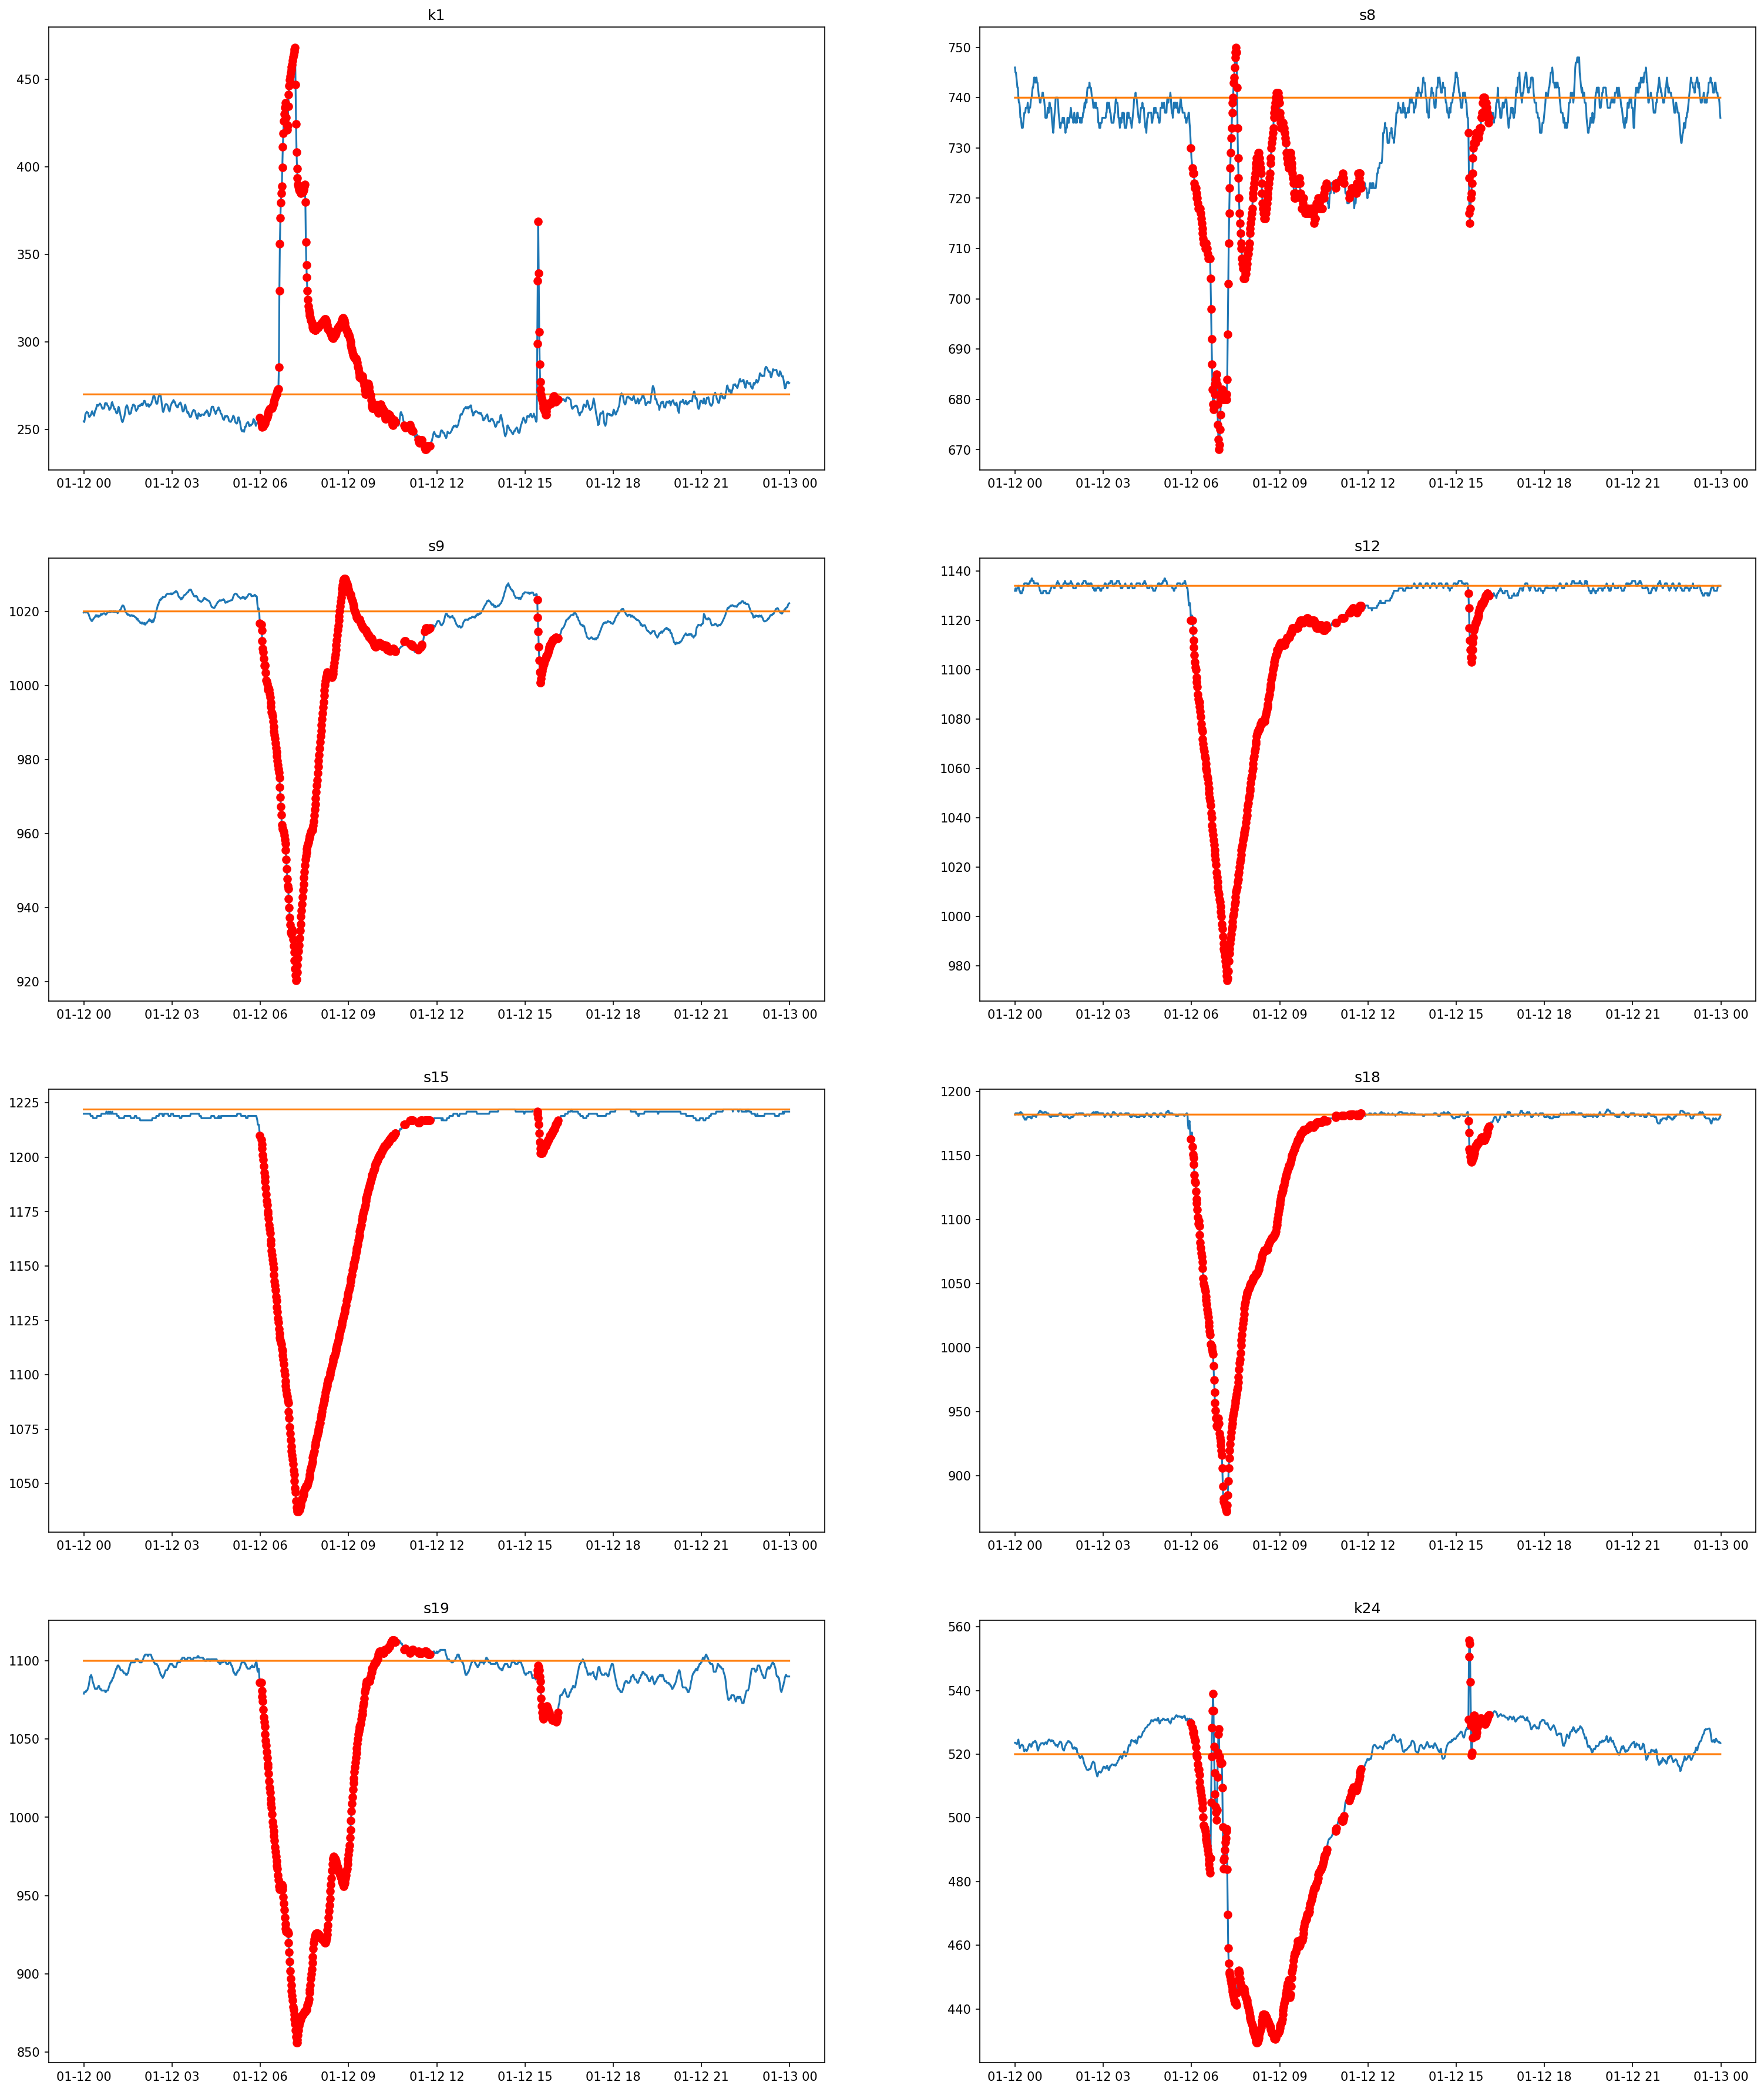

In [27]:
plot_anomalias('2024-01-12', dftemp, res,muestras_)

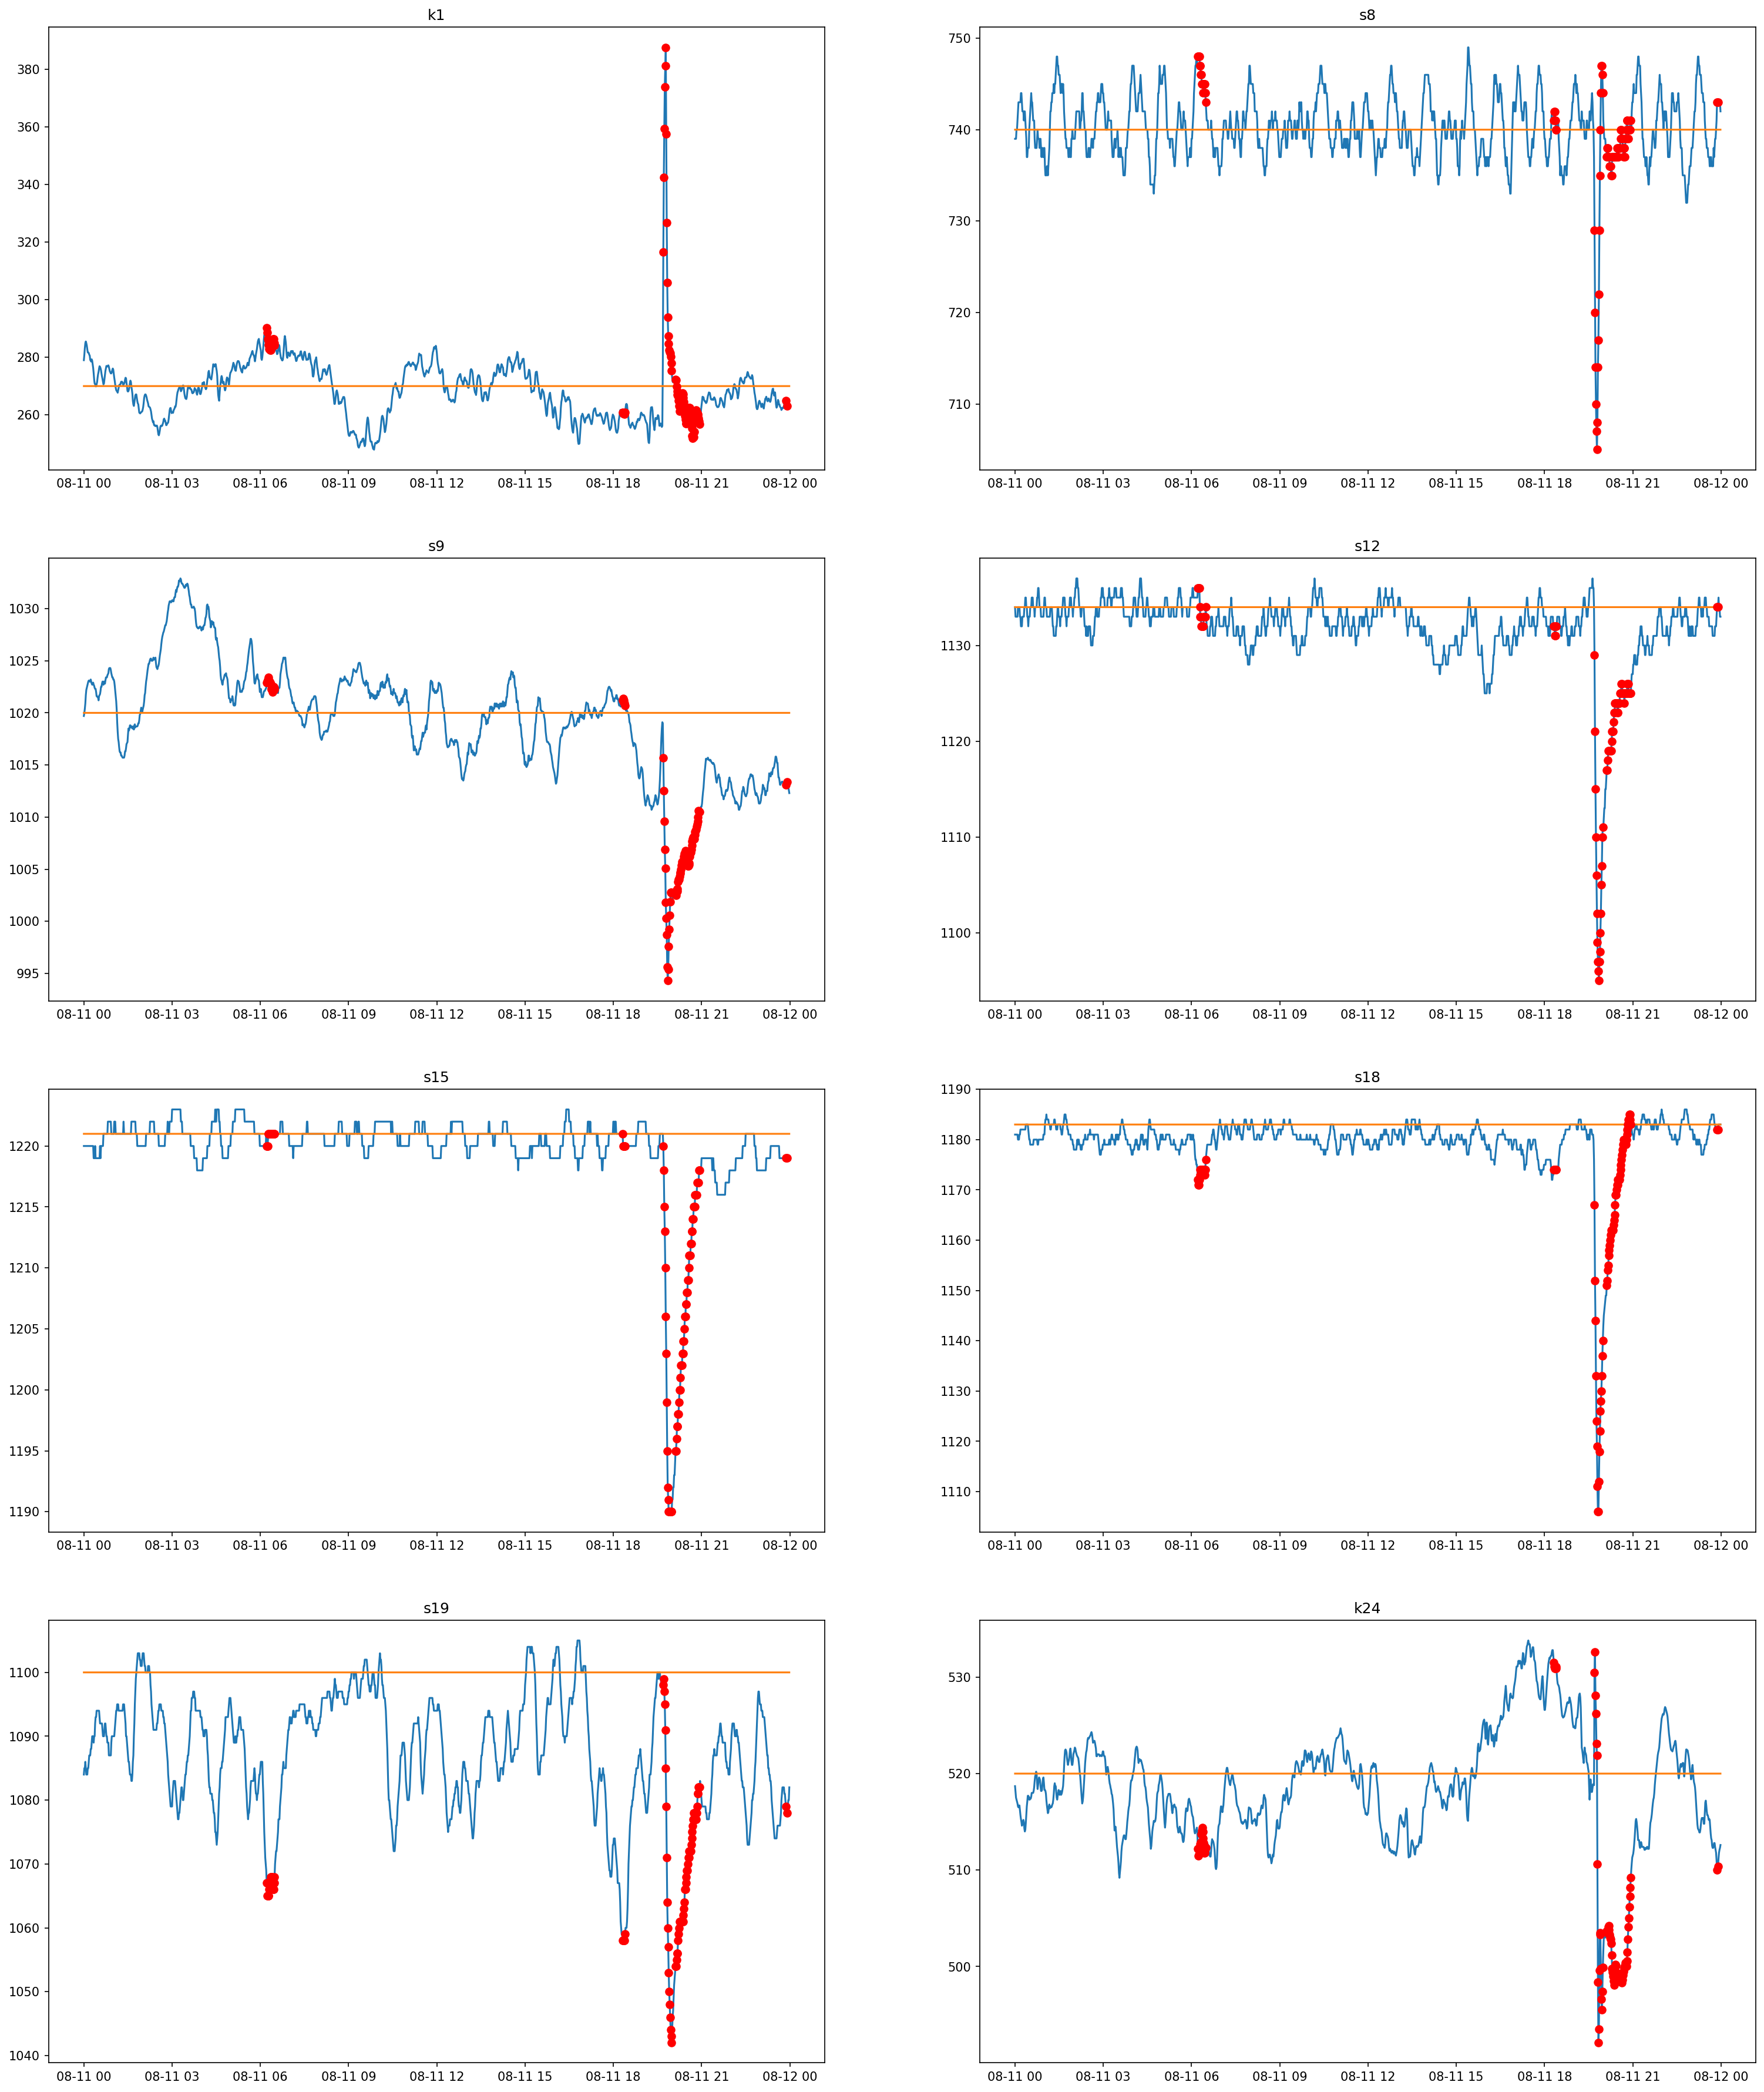

In [28]:
plot_anomalias('2024-08-11', dftemp, res,muestras_)

# Create a Dataset

<Axes: xlabel='_time'>

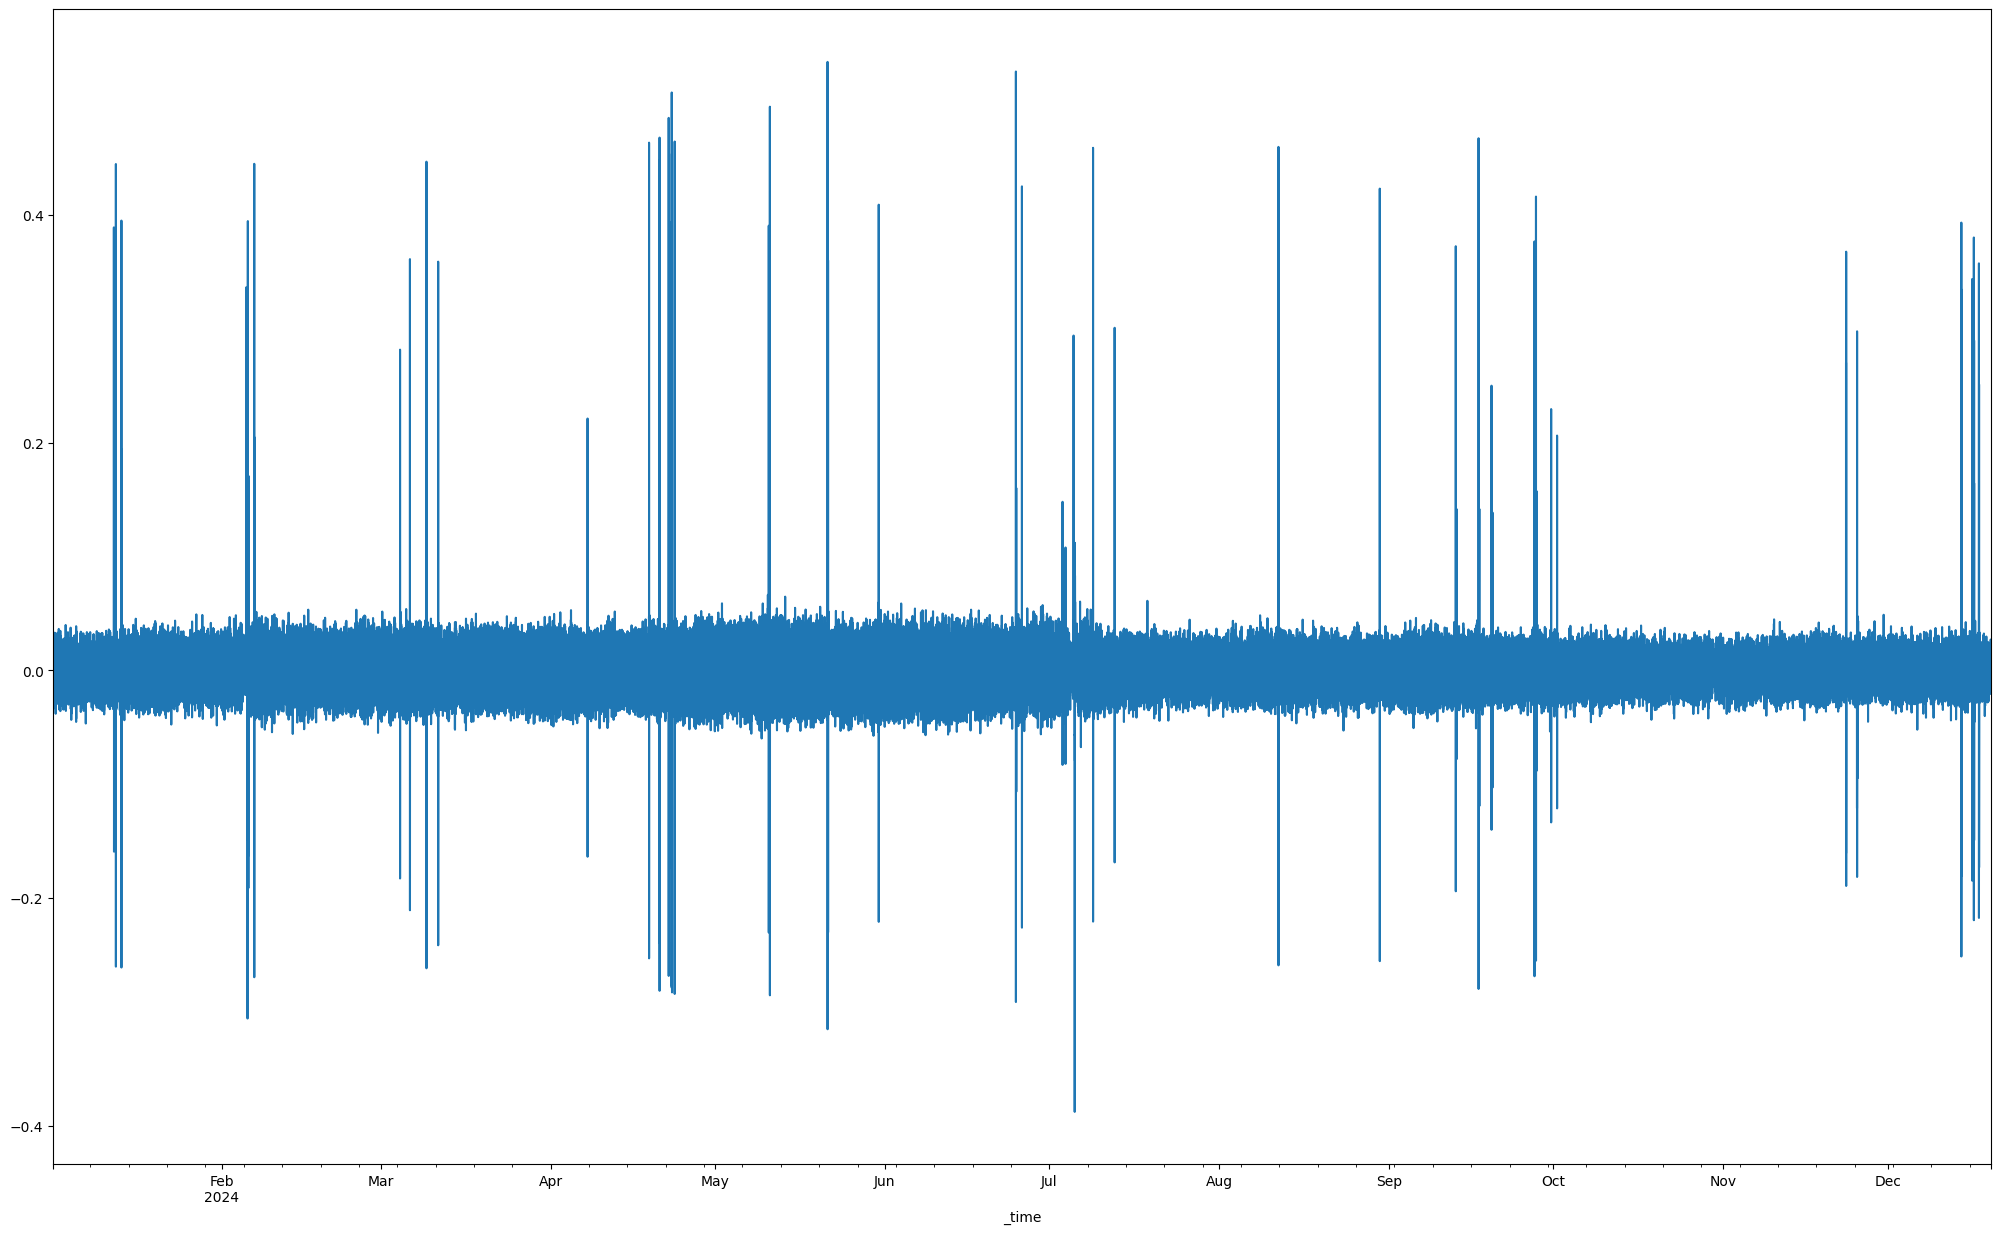

In [33]:
dftemp['k1'].pct_change(5).plot(figsize=(25,15))

In [82]:
dfpct=pd.DataFrame()
for k in termo_horno:
    if k!='s10':
        dfpct[k+'pct']=dftemp[k].pct_change(13)

In [83]:
dfpct=dfpct.dropna()

<Axes: >

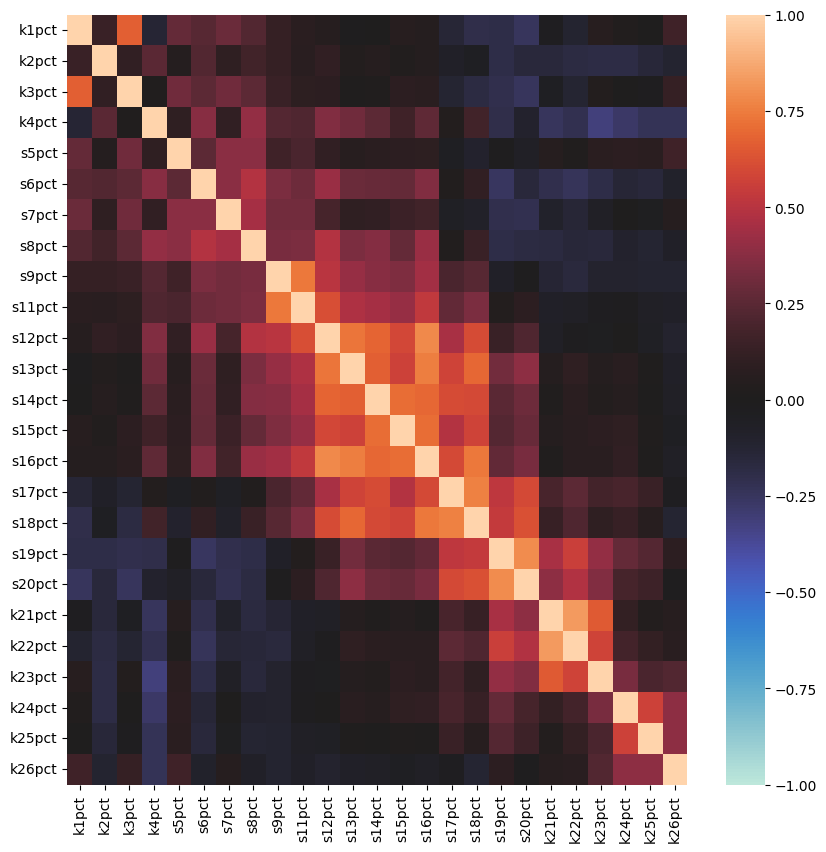

In [84]:
plt.figure(figsize=(10,10))
sns.heatmap(dfpct.corr(), vmin=-1.0, vmax=1.0,center=0.0)

# Experimento 1

In [120]:
def venana_des_sencilla_tensor(df,Tmuestas,xmuestra):
    X_a=[]
    for i in range(Tmuestas):
        X_a.append(df[i:i+int(xmuestra)].T)
    X_a=np.array(X_a)
    return X_a

In [121]:
Xhora=venana_des_sencilla_tensor(dftemp[termo_horno].values,dftemp.shape[0]-60,60)

In [122]:
def images_gen(X):
    img_=[]
    for i in range(X.shape[0]):
        img_.append(X[i].T/X[i].T.max(axis=0))
    return np.array(img_)

In [123]:
Xhimg=images_gen(Xhora)

In [125]:
Xhimg.shape

(509134, 60, 26)

In [ ]:
# np.save('data.npy', Xhimg)
#np.save('yvalue.npy', res)

# Images

In [ ]:
from scipy.ndimage import gaussian_filter

In [2]:
X= np.load('data.npy')
y0=np.load('yvalue.npy')

In [3]:
ya=np.where(y0==-1,1,0)

In [38]:
ya[62:62+60]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
ej=gaussian_filter(X[120:123:,:,:].T, sigma=1.25)

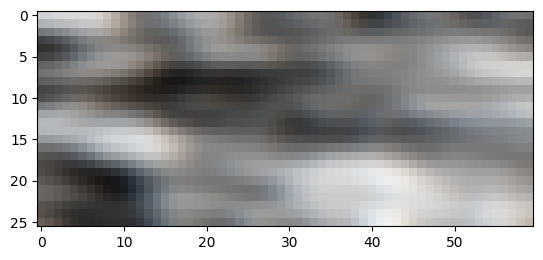

In [17]:
plt.imshow(gaussian_filter(X[120:123:,:,:].T, sigma=1.25))

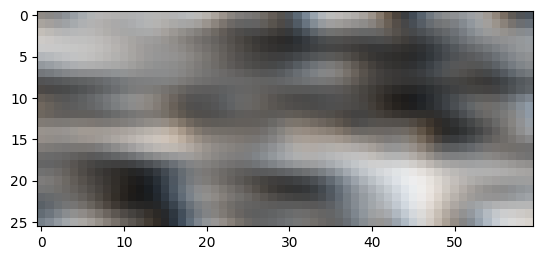

In [13]:
plt.imshow(gaussian_filter(X[60:63:,:,:].T, sigma=1.25))

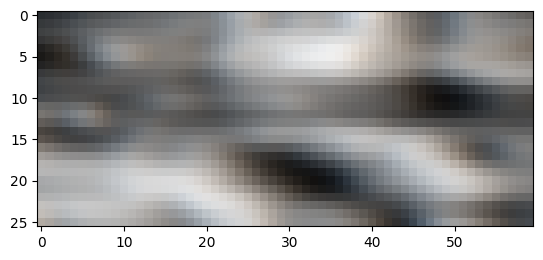

In [9]:
plt.imshow(gaussian_filter(X[0:3:,:,:].T, sigma=1.25))

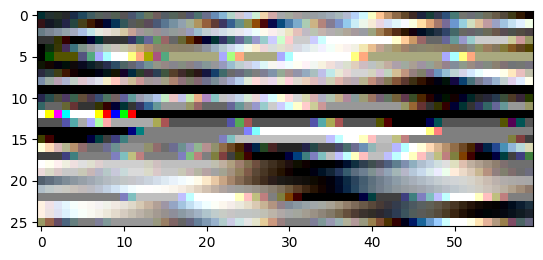

In [4]:
plt.imshow(X[0:3:,:,:].T)

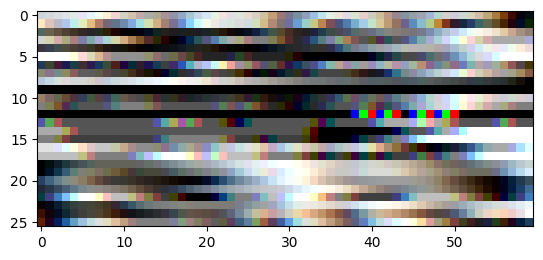

In [33]:
plt.imshow(X[74:74+3:,:,:].T)

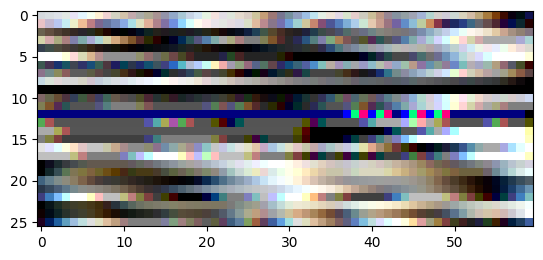

In [113]:
plt.imshow(X[75:75+3:,:,:].T)

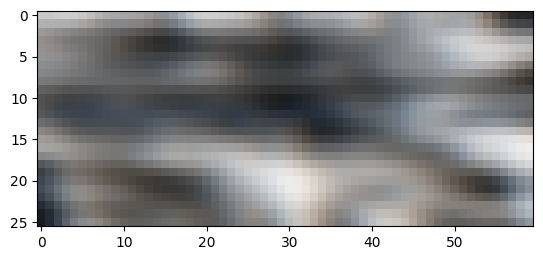

In [19]:
plt.imshow(gaussian_filter(X[75:75+3:,:,:].T, sigma=1.25))

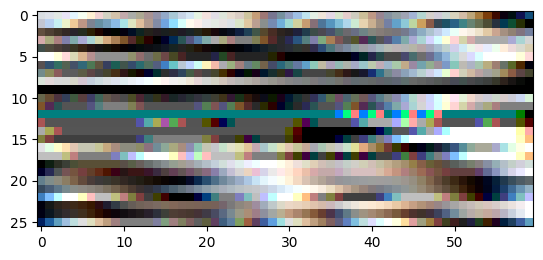

In [114]:
plt.imshow(X[76:76+3:,:,:].T)

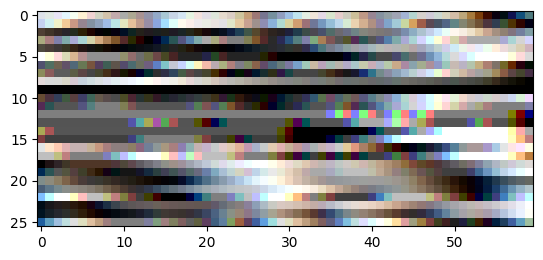

In [116]:
plt.imshow(X[77:77+3:,:,:].T)

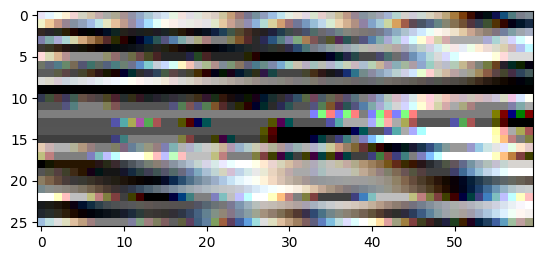

In [118]:
plt.imshow(X[79:79+3:,:,:].T)

In [ ]:
ya[75:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
X.shape

(509134, 60, 26)

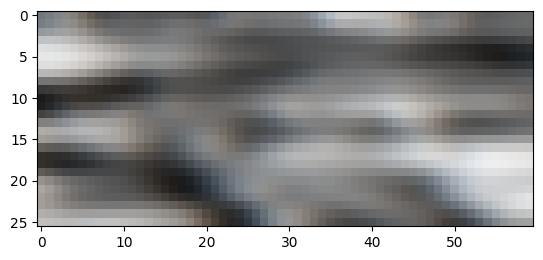

In [23]:
plt.imshow(gaussian_filter(X[500000:500003:,:,:].T, sigma=1.25))

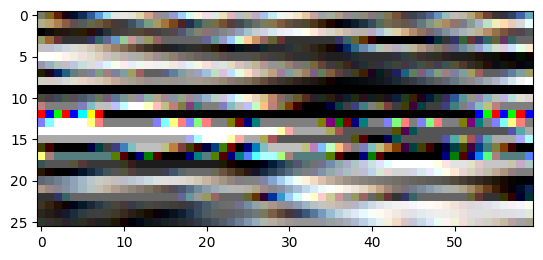

In [94]:
plt.imshow(X[9003:9006:,:,:].T)

In [102]:
X.shape

(509134, 60, 26)

In [101]:
X[9003:9006:,0,0]*255

array([119.        , 124.66666667, 102.        ])

In [85]:
ya[60:63]

array([0, 0, 0])

In [23]:
X.shape

(509134, 60, 26)

In [24]:
y0.shape

(509194,)

In [40]:
Y=ya[60:].copy()
#Y=Y.reshape((-1,1))

In [41]:
anom=[]
for i in range(Y.shape[0]-60):
    K=Y[i:i+60].sum()/np.int64(60)
    if K>=0.4:
        anom.append(1)
    else:
        anom.append(0)
anom=np.array(anom)

In [ ]:
def cadena_markov(y):
    valores=np.unique(y).astype(str)
    

In [42]:
ubicaciones_1=np.where(anom==1)[0]

In [43]:
ubicaciones_0=np.where(anom==0)[0]

In [44]:
ubicaciones_00=np.random.choice(ubicaciones_0, size=ubicaciones_1.shape[0], replace=False)

In [45]:
xubicaciones=np.sort(np.concat((ubicaciones_00,ubicaciones_1)))

In [46]:
Ximg=X[xubicaciones]

In [47]:
yanom=anom[xubicaciones].reshape((-1,1))

In [49]:
import tensorflow as tf
from keras.layers import Dense, Input, Flatten, Dropout, Conv1D
from keras.optimizers import RMSprop
from keras import Sequential

In [50]:
modelo_01=Sequential()
modelo_01.add(Input(shape=(60, 26)))
modelo_01.add(Conv1D(60,2, activation='linear'))
modelo_01.add(Dropout(0.25))
modelo_01.add(Dense(180, activation='relu'))
modelo_01.add(Dense(90, activation='leaky_relu'))
modelo_01.add(Dropout(0.25))
modelo_01.add(Flatten())
modelo_01.add(Dense(1, activation='sigmoid'))


In [51]:
modelo_01.compile(optimizer=RMSprop(learning_rate=0.0001), loss ='binary_crossentropy',metrics = ['accuracy'])

In [85]:
alfa=0.5039876
modelo_01.fit(Ximg,yanom, epochs=12, batch_size=150, validation_split=0.3, class_weight={0:1-alfa,1:alfa})

Epoch 1/12
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - accuracy: 0.7250 - loss: 0.2723 - val_accuracy: 0.6197 - val_loss: 0.6857
Epoch 2/12
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.7298 - loss: 0.2687 - val_accuracy: 0.6116 - val_loss: 0.7083
Epoch 3/12
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.7324 - loss: 0.2660 - val_accuracy: 0.6294 - val_loss: 0.6815
Epoch 4/12
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.7364 - loss: 0.2636 - val_accuracy: 0.6362 - val_loss: 0.6720
Epoch 5/12
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.7395 - loss: 0.2617 - val_accuracy: 0.6403 - val_loss: 0.6619
Epoch 6/12
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.7414 - loss: 0.2601 - val_accuracy: 0.6121 - val_loss: 0.7293
Epoch 7/12
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.7450 - loss: 0.2566 - val_accuracy: 0.6232 - val_loss: 0.7054
Epoch 8/12
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.7504 -

In [86]:
yhat=modelo_01.predict(Ximg, verbose=0)

In [69]:
from sklearn.metrics import confusion_matrix, precision_score,brier_score_loss


In [87]:
yhat2=np.where(yhat.ravel()>=0.5,1,0)

In [88]:
confusion_matrix(yanom.ravel(), yhat2, labels=[1,0])

array([[77889, 29467],
       [26507, 80849]])

In [89]:
precision_score(yanom.ravel(), yhat2)

np.float64(0.746091804283689)

In [90]:
brier_score_loss(yanom.ravel(), yhat2)

np.float64(0.2606933939416521)